# Strategy for Buy & Sell(Swing Trading)

Objective: We will code a strategy to exit any position which can be buy, sell, hold or no position. With this strategy will will identify the opportunity to get on board with relly(long and short both) and deboard when stop loss get triggered.

In [1]:
import numpy as np
import pandas as pd
from alpha_vantage.timeseries import TimeSeries
import copy
import time
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 200)
pd.set_option('display.min_rows', 100)

In [3]:
#using ATR strategy to exit the positions
#function to calculate True Range and Average True Range
def ATR(DF,n):
    df = DF.copy()
    df['H-L']=abs(df['High']-df['Low'])
    df['H-PC']=abs(df['High']-df['Close'].shift(1))
    df['L-PC']=abs(df['Low']-df['Close'].shift(1))
    df['TR']=df[['H-L','H-PC','L-PC']].max(axis=1,skipna=False)
    df['ATR'] = df['TR'].rolling(n).mean()
    #df['ATR'] = df['TR'].ewm(span=n,adjust=False,min_periods=n).mean()
    df2 = df.drop(['H-L','H-PC','L-PC'],axis=1)
    return df2['ATR']

In [4]:
# Download historical data (monthly) for selected stocks
tickers = ["MSFT","AAPL","FB","AMZN","INTC", "CSCO","VZ","IBM","TSLA","AMD"]

In [5]:
key_path = "C:\\Users\\punit\\Desktop\\9010\\AplhaVantageKey.txt"
ts = TimeSeries(key=open(key_path,'r').read(), output_format='pandas')

In [6]:
ohlc_intraday = {}  # directory with ohlc value for each stock
api_call_count = 1
start_time = time.time()

In [7]:
for ticker in tickers:
    data = ts.get_intraday(symbol=ticker,interval='5min', outputsize='full')[0]
    api_call_count+=1
    data.columns = ["Open","High","Low","Close","Volume"]
    data = data.iloc[::-1]
    data = data.between_time('09:35', '16:00') #remove data outside regular trading hours
    ohlc_intraday[ticker] = data
    if api_call_count==5:
        api_call_count = 1
        time.sleep(60 - ((time.time() - start_time) % 60.0))

tickers = ohlc_intraday.keys() # redefine tickers variable after removing any tickers with corrupted data

In [8]:
# calculating ATR and rolling max price for each stock and consolidating this info by stock in a separate dataframe
ohlc_dict = copy.deepcopy(ohlc_intraday)
tickers_signal = {}
tickers_ret = {}
for ticker in tickers:
    print("calculating ATR and rolling max price for ",ticker)
    ohlc_dict[ticker]["ATR"] = ATR(ohlc_dict[ticker],20)
    ohlc_dict[ticker]["roll_max_cp"] = ohlc_dict[ticker]["High"].rolling(20).max()
    ohlc_dict[ticker]["roll_min_cp"] = ohlc_dict[ticker]["Low"].rolling(20).min()
    ohlc_dict[ticker]["roll_max_vol"] = ohlc_dict[ticker]["Volume"].rolling(20).max()
    ohlc_dict[ticker].dropna(inplace=True)
    tickers_signal[ticker] = ""
    tickers_ret[ticker] = []

calculating ATR and rolling max price for  MSFT
calculating ATR and rolling max price for  AAPL
calculating ATR and rolling max price for  FB
calculating ATR and rolling max price for  AMZN
calculating ATR and rolling max price for  INTC
calculating ATR and rolling max price for  CSCO
calculating ATR and rolling max price for  VZ
calculating ATR and rolling max price for  IBM
calculating ATR and rolling max price for  TSLA
calculating ATR and rolling max price for  AMD


In [9]:
# identifying signals and calculating daily return (stop loss factored in)
for ticker in tickers:
    print("calculating returns for ",ticker)
    for i in range(len(ohlc_dict[ticker])):
        if tickers_signal[ticker] == "":
            tickers_ret[ticker].append(0)
            if ohlc_dict[ticker]["High"][i]>=ohlc_dict[ticker]["roll_max_cp"][i] and \
               ohlc_dict[ticker]["Volume"][i]>1.5*ohlc_dict[ticker]["roll_max_vol"][i-1]:
                tickers_signal[ticker] = "Buy"
            elif ohlc_dict[ticker]["Low"][i]<=ohlc_dict[ticker]["roll_min_cp"][i] and \
               ohlc_dict[ticker]["Volume"][i]>1.5*ohlc_dict[ticker]["roll_max_vol"][i-1]:
                tickers_signal[ticker] = "Sell"
        
        elif tickers_signal[ticker] == "Buy":
            if ohlc_dict[ticker]["Low"][i]<ohlc_dict[ticker]["Close"][i-1] - ohlc_dict[ticker]["ATR"][i-1]:
                tickers_signal[ticker] = ""
                tickers_ret[ticker].append(((ohlc_dict[ticker]["Close"][i-1] - ohlc_dict[ticker]["ATR"][i-1])/ohlc_dict[ticker]["Close"][i-1])-1)
            elif ohlc_dict[ticker]["Low"][i]<=ohlc_dict[ticker]["roll_min_cp"][i] and \
               ohlc_dict[ticker]["Volume"][i]>1.5*ohlc_dict[ticker]["roll_max_vol"][i-1]:
                tickers_signal[ticker] = "Sell"
                tickers_ret[ticker].append((ohlc_dict[ticker]["Close"][i]/ohlc_dict[ticker]["Close"][i-1])-1)
            else:
                tickers_ret[ticker].append((ohlc_dict[ticker]["Close"][i]/ohlc_dict[ticker]["Close"][i-1])-1)
                
        elif tickers_signal[ticker] == "Sell":
            if ohlc_dict[ticker]["High"][i]>ohlc_dict[ticker]["Close"][i-1] + ohlc_dict[ticker]["ATR"][i-1]:
                tickers_signal[ticker] = ""
                tickers_ret[ticker].append((ohlc_dict[ticker]["Close"][i-1]/(ohlc_dict[ticker]["Close"][i-1] + ohlc_dict[ticker]["ATR"][i-1]))-1)
            elif ohlc_dict[ticker]["High"][i]>=ohlc_dict[ticker]["roll_max_cp"][i] and \
               ohlc_dict[ticker]["Volume"][i]>1.5*ohlc_dict[ticker]["roll_max_vol"][i-1]:
                tickers_signal[ticker] = "Buy"
                tickers_ret[ticker].append((ohlc_dict[ticker]["Close"][i-1]/ohlc_dict[ticker]["Close"][i])-1)
            else:
                tickers_ret[ticker].append((ohlc_dict[ticker]["Close"][i-1]/ohlc_dict[ticker]["Close"][i])-1)
                
    ohlc_dict[ticker]["ret"] = np.array(tickers_ret[ticker])

calculating returns for  MSFT
calculating returns for  AAPL
calculating returns for  FB
calculating returns for  AMZN
calculating returns for  INTC
calculating returns for  CSCO
calculating returns for  VZ
calculating returns for  IBM
calculating returns for  TSLA
calculating returns for  AMD


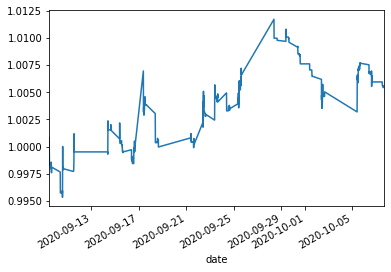

In [10]:
# vizualization of strategy return
strategy_df = pd.DataFrame()
for ticker in tickers:
    strategy_df[ticker] = ohlc_dict[ticker]["ret"]
strategy_df["ret"] = strategy_df.mean(axis=1)
(1+strategy_df["ret"]).cumprod().plot()